In [ ]:
!nvidia-smi

Thu Jul 29 12:51:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 277 (delta 59), reused 40 (delta 20), pack-reused 171
Receiving objects: 100% (277/277), 80.66 KiB | 16.13 MiB/s, done.
Resolving deltas: 100% (121/121), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bio

In [ ]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:36
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!python rapidsai-csp-utils/colab/install_rapids.py core
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Installing RAPIDS Stable 21.06
Starting the RAPIDS+BlazingSQL install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - gcsfs
    - llvmlite
    - openssl
    - python=3.7
    - rapids-blazing=21.06


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20210324.1      |       h9c3ff4c_0        1015 KB  conda-forge
    aiohttp-3.7.4.post0        |   py37h5e8e339_0         625 KB  conda-forge
    anyio-3.3.0                |   py37h89c1867_0         146 KB  conda-forge
    argon2-cffi-20.1.0         |   py37h5e8e339_2      

In [ ]:
import pandas as pd
import cudf
dataset=pd.read_csv("result.csv",sep=",")

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset.loc[:,'content'] = dataset.loc[:,'content'].str.lower()

In [ ]:
dataset.loc[:,'content'] = dataset.loc[:,'content'].str.replace('[^\w\s]','')

In [ ]:
dataset.loc[:,'content'] = dataset.loc[:,'content'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
from sklearn.model_selection import train_test_split
content=dataset.loc[:,'content']
result=dataset.loc[:,'result']
X_train, X_test, y_train, y_test = train_test_split(content, 
                                                    result, 
                                                    train_size = 0.80,
                                                    shuffle = True,
                                                    random_state = 45
                                                    )

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from cuml.naive_bayes import MultinomialNB
count_vect = CountVectorizer()
features = count_vect.fit_transform(X_train)

In [ ]:
import cupy as cp
import cupyx
X = cupyx.scipy.sparse.csr_matrix(features.tocsr(), dtype=cp.float32)
y = cp.asarray(y_train, dtype=cp.int32)

In [ ]:
model = MultinomialNB()
model.fit(X, y)

MultinomialNB()

In [ ]:
model.score(X, y)

0.9450609087944031

In [ ]:
features1 = count_vect.transform(X_test)
X1 = cupyx.scipy.sparse.csr_matrix(features1.tocsr(), dtype=cp.float32)

In [ ]:
from sklearn import metrics
y1=model.predict(X1)


In [ ]:
print(metrics.classification_report(y_test, y1.get()))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     29153
           1       0.90      0.87      0.88     16808

    accuracy                           0.92     45961
   macro avg       0.91      0.91      0.91     45961
weighted avg       0.92      0.92      0.92     45961



In [ ]:
matriz=metrics.confusion_matrix(y_test, y1.get())
matriz

array([[27601,  1552],
       [ 2254, 14554]])

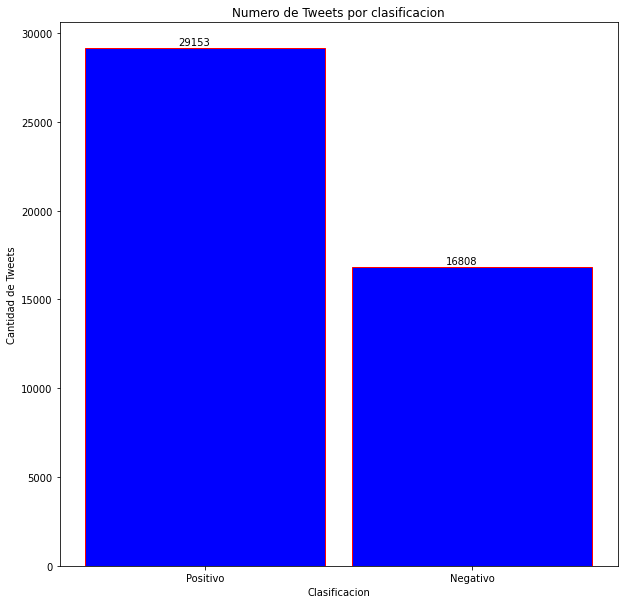

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
eje_x = ['Positivo','Negativo']
eje_y = [matriz[0,:].sum(),matriz[1,:].sum()]
plt.bar(eje_x, eje_y,width= 0.9, align='center',color='blue', edgecolor = 'red')
for i in range(len(eje_x)):
    plt.annotate(eje_y[i], (-0.1 + i, eje_y[i] + 200))
plt.ylabel('Cantidad de Tweets')
plt.xlabel('Clasificacion')
plt.title('Numero de Tweets por clasificacion')
plt.show()

In [ ]:
import tweepy
import json
consumer_key="9gJoiM1bnpyITgsckQ7RObdku"
consumer_secret_key="62unmXGyRntFPUxgG10eMB6YoA5F4H95opEVzomeXJ7fKX34UF"
access_token="1183101625914810368-WWmDXgBajyMNUqKSA0tW97J3FbKQIg"
access_secret_token="n5qVkZWxVmZLcsFcGzwuECxDdZExvaEpNjOTy1pgrtYsh"
auth=tweepy.OAuthHandler(consumer_key,consumer_secret_key)
auth.set_access_token(access_token,access_secret_token)
api=tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [ ]:
tweets=[]
for tweet in tweepy.Cursor(api.user_timeline,screen_name="DeToxicas",tweet_mode="extendend").items(15):  
  aux=tweet._json["text"]
  tweets.append(aux)
salida=pd.Series(tweets)
featurest = count_vect.transform(salida)
Xt = cupyx.scipy.sparse.csr_matrix(featurest.tocsr(), dtype=cp.float32)
prediccion=model.predict(Xt)
print(prediccion)

[1 1 0 0 0 0 0 0 0 0 0 1 0 1 1]


In [ ]:
tweets

['Página de facebook en venta con 325 mil seguidores, ideal para publicidad. Informes por DM',
 'Mátenme ese recuerdo de ese amargo amor',
 'Cuál perdón? Págame la terapia puto imbécil',
 'Ya no sé qué chingados publicar...\n¿Ya lloraron hoy?',
 'Mi mamá: matemáticas es fácil\n\nEl profe: calculé con cuántas las engañó su ex',
 'Aún están a tiempo para pelearse y evitar gastar el 14 de febrero https://t.co/dZjzu7xhUM',
 'A esta edad, uno ya no se interesa por el físico, sino busca a alguien que ya no hable de su pinche Ex.',
 'A veces sólo hay que decir "Sisi ya ala chingada teme cuidas" y seguir con tu vida',
 'Una lloradita y a seguir puteando',
 'Donde le valgas verga ahí es 🥰',
 'Yo: Familia, les presento a mi novio.\n\nMi novio: Hola a todos.\n\nMi marido: De verdad que tú no tienes madre.',
 'Diciembre con "D" de "Date cuenta amiga"',
 'Ya eres el tejocote de otro ponche',
 'no sé ligar, pero te puedo hacer piojito',
 'perdón por encularme es q me gusta que me pongan jjajajaj des

In [ ]:
tweetsB=[]
for tweet in tweepy.Cursor(api.search,q="pendejada",tweet_mode="extendend").items(15):  
  auxB=tweet._json["text"]
  tweetsB.append(auxB)
salidaB=pd.Series(tweetsB)
featuresb = count_vect.transform(salidaB)
Xb = cupyx.scipy.sparse.csr_matrix(featuresb.tocsr(), dtype=cp.float32)
prediccionb=model.predict(Xb)
print(prediccionb)

[0 1 1 0 0 0 1 1 0 0 1 0 0 0 0]


In [ ]:
tweetsB

['@NoveleraSoy @SandyPamanes @disenandotuamor Ya no soporto tanta estupidez. Van 66 episodios de tanta pendejada y no pasa NADA.',
 'RT @Anmmo8: Depende del tema.\n\nA veces hay Icebergs de tema muy interesantes, que acompañados de una buena investigación pueden ser entrete…',
 'Depende del tema.\n\nA veces hay Icebergs de tema muy interesantes, que acompañados de una buena investigación pueden… https://t.co/9noSJ8UIRp',
 '@ActualidadRT Respuesta: en una pendejada.',
 '#NoVacunarse es una reveranda pendejada, vacúnense o déjennos vacunarnos a los que si queremos, no jodás',
 'RT @Mexicano100PC: Ya cansan con tanta pendejada. Ya no saben cómo ocultar su gigantesco fracaso. Jauría de imbéciles.',
 'RT @JevyMerol: @monicagarzag @gabrielguerrac La Poliomielitis se erradicó en México y el mundo , gracias a la vacuna . Mientras los pseudo…',
 'Soy una gran admiradora de muchas personas, pero eso no significa que si hacen una pendejada los voy a defender o s… https://t.co/9xVo7h5GM0',
 '@eles

In [ ]:
print(X1)

  (0, 4900)	1.0
  (0, 15312)	1.0
  (0, 51514)	1.0
  (0, 51641)	1.0
  (0, 64201)	1.0
  (0, 80787)	1.0
  (0, 89079)	2.0
  (0, 91191)	1.0
  (0, 98647)	1.0
  (0, 99070)	1.0
  (1, 12007)	1.0
  (1, 20554)	1.0
  (1, 20656)	1.0
  (1, 31671)	1.0
  (1, 50200)	1.0
  (1, 70389)	1.0
  (1, 73964)	1.0
  (1, 74334)	1.0
  (1, 76753)	1.0
  (2, 16586)	1.0
  (2, 25429)	1.0
  (2, 30503)	1.0
  (2, 37066)	1.0
  (2, 41239)	1.0
  (2, 41398)	1.0
  :	:
  (45955, 38269)	1.0
  (45955, 69535)	1.0
  (45955, 88553)	1.0
  (45955, 98472)	1.0
  (45956, 36469)	1.0
  (45956, 73595)	1.0
  (45956, 80795)	1.0
  (45956, 88529)	1.0
  (45956, 89782)	1.0
  (45956, 89974)	1.0
  (45956, 92025)	1.0
  (45956, 92396)	1.0
  (45956, 92569)	1.0
  (45957, 69599)	1.0
  (45957, 87914)	1.0
  (45957, 101058)	1.0
  (45958, 34014)	1.0
  (45959, 48473)	1.0
  (45959, 54494)	1.0
  (45959, 59165)	1.0
  (45959, 90310)	1.0
  (45959, 93075)	1.0
  (45960, 14259)	1.0
  (45960, 25894)	1.0
  (45960, 52283)	1.0
